# Практическое задание к уроку 1. Основы обучения нейронных сетей

1. Попробуйте видоизменить параметры разобранной на уроке двухслойной нейронной сети таким образом, чтобы улучшить ее точность (число нейронов, число эпох , можно изменять число слоев).
2. Проведите анализ — что приводит к ухудшению точности нейронной сети? Что приводит к увеличению ее точности?

Мы разобрались с основами обучения нейронных сетей и получили некоторое представление об архитектурах простых нейронных сетей. Давайте попробуем закрепить эти знания на практике. Кроме того на примере который будет изложен ниже возможно проясняться какие-либо оставшиеся вопросы.

В данном примере мы сделаем нейронную сеть которая будет отличать различные виды ириса между собой. Надо полагать данный датасет вам уже знаком. Логика работы этого кода будет такой же как и в первом разобранном примере, но только все компоненты этого кода будут несколько усложнены.

In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return (x)*(1 - (x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


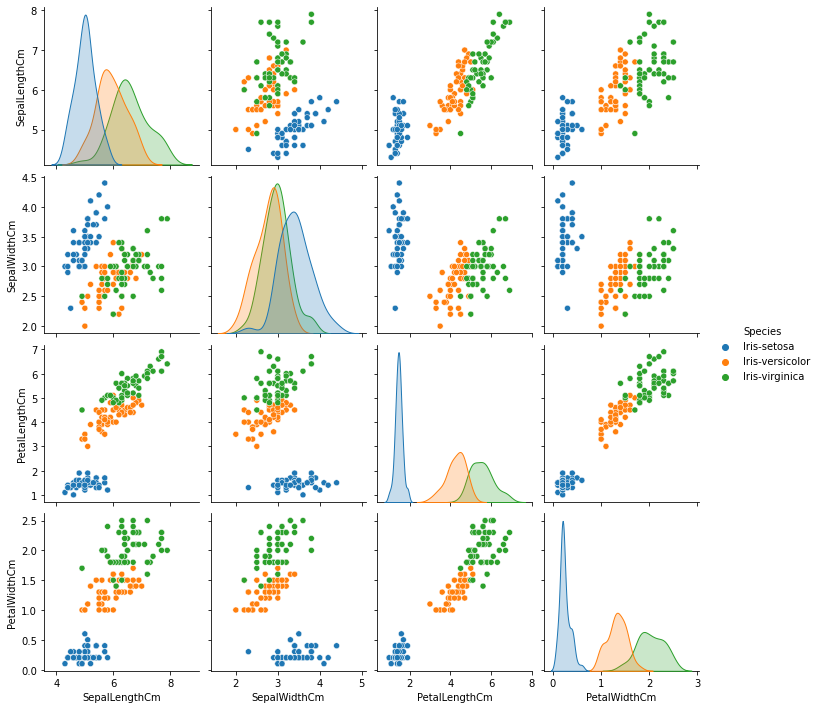

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
# x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
# y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [4]:
### Шаг 3. Обученние нейронной сети

# определим число нейронов скрытого слоя
neuron_numb = 5

# присваевание случайных весов

w0 = 2*np.random.random((4, neuron_numb)) - 1 # для входного слоя   - 4 входа, 3 выхода
w1 = 2*np.random.random((neuron_numb, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

# скорость обучения (learning rate)
n = 0.15 # 0.005

# массив для ошибок, чтобы потом построить график
errors = []
errors_test = []

# процесс обучения
for i in range(5000): # 3000, далее 15000

    # прямое распространение(feed forward)
    layer0 = X_train
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = sigmoid(np.dot(layer1, w1))
    
    layer0_test = X_test
    layer1_test = sigmoid(np.dot(layer0_test, w0))
    layer2_test = sigmoid(np.dot(layer1_test, w1))

    # обратное распространение(back propagation) с использованием градиентного спуска
    layer2_error = y_train - layer2 # производная функции потерь = производная квадратичных потерь 
    layer2_delta = layer2_error * sigmoid_deriv(layer2)
    
    layer2_error_test = y_test - layer2_test
    
    layer1_error = layer2_delta.dot(w1.T)
    layer1_delta = layer1_error * sigmoid_deriv(layer1)
    
    # коррекция
    w1 += layer1.T.dot(layer2_delta) * n
    w0 += layer0.T.dot(layer1_delta) * n
    
    # метрика модели
    error = np.mean(np.abs(layer2_error))
    error_test = np.mean(np.abs(layer2_error_test))
    
    errors.append(error)
    errors_test.append(error_test)
    
    accuracy = (1 - error) * 100
    accuracy_test = (1 - error_test) * 100

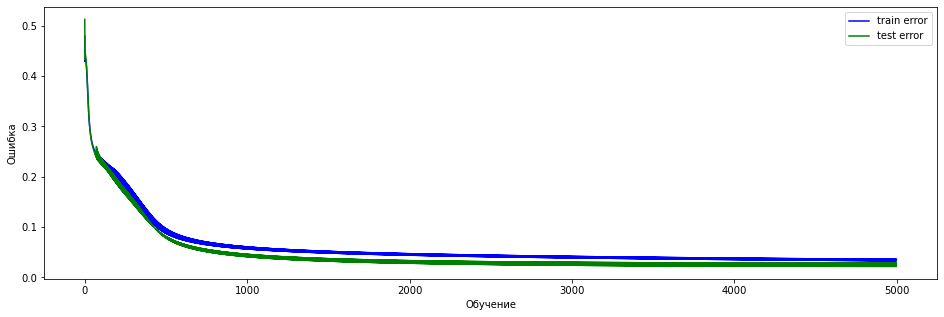

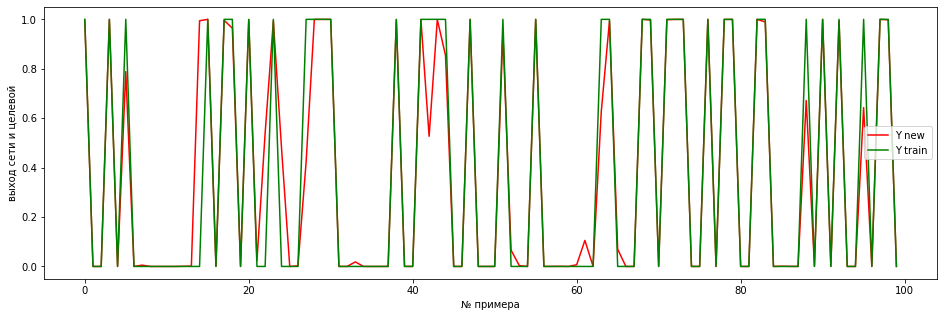

Аккуратность нейронной сети 96.41%
Аккуратность нейронной сети тестовой выборки 97.19%


In [5]:
### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5)) # 16,5 далее 20,10
# plt.plot(errors)
plt.plot(errors, 'b', label='train error')
plt.plot(errors_test, 'g', label='test error')

plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.legend()
plt.show() # расскоментируйте, чтобы посмотреть 

N = 100 # 50
plt.figure(figsize = (16,5)) # 16,5 далее 20,10
plt.plot(layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть 
        
print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
print("Аккуратность нейронной сети тестовой выборки " + str(round(accuracy_test,2)) + "%")

С дальнейшим увеличением learning rate аккуратность тестовой выборки падает.

w0: [[ 5.43242940e-03 -3.66670010e-01 -3.48927214e-01  3.36250465e-01
   4.11764760e-01 -6.86815976e-01  3.36994499e-01 -3.67108453e-01
   8.39491114e-01  9.13884218e-01]
 [-9.63337899e-01  8.16945027e-01 -7.20755475e-01 -6.58197861e-02
  -3.91513349e-01 -1.11659451e-01 -1.63793659e-01 -2.54715725e-01
   2.62826444e-01 -6.94827494e-01]
 [-5.55986138e-02  4.78725768e-01 -1.73011394e-01 -1.38332232e-01
  -2.13715567e-01  4.26549176e-01  3.50968755e-01  4.88619668e-01
   4.93583561e-01 -5.74841339e-01]
 [-7.30495780e-01  9.89652165e-01 -8.89983494e-04  7.28170637e-01
  -2.99983100e-01  6.54100340e-01  3.21350455e-01  3.86970711e-01
   7.24231308e-01  1.42686481e-01]]
w1: [[ 0.34162543  0.80542514 -0.82199273]
 [-0.03984469 -0.52823847 -0.97250202]
 [-0.24397613 -0.14361066 -0.92800133]
 [-0.41225038  0.99732667 -0.83271687]
 [ 0.68075063  0.66279943 -0.25720699]
 [-0.66836892  0.05399035  0.03525398]
 [ 0.16095944 -0.62962606  0.79152655]
 [ 0.17716898  0.8456159   0.78370198]
 [-0.953381

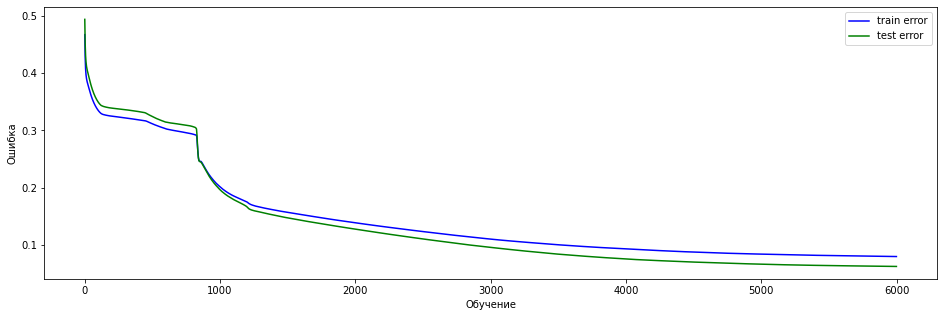

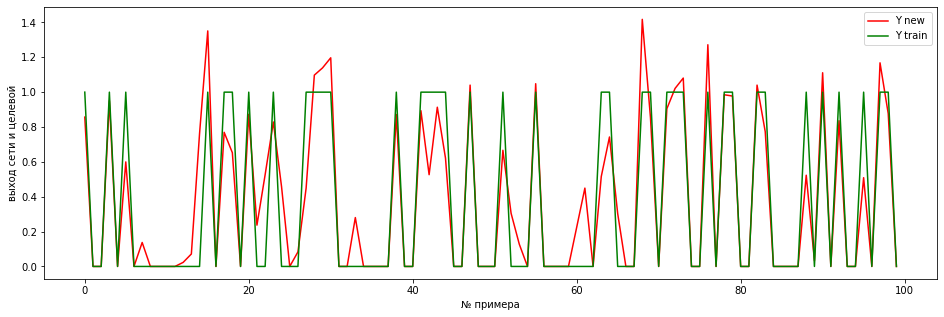

Аккуратность нейронной сети 92.05%
Аккуратность нейронной сети тестовой выборки 93.78%


In [11]:
def ReLU(x):
    return x * (x > 0)

def dReLU(z):
    return np.where(z <= 0, 0, 1)

   
### Шаг 3. Обученние нейронной сети
# присваевание случайных весов
w0 = 2*np.random.random((4, 10)) - 1 # для входного слоя   - 4 входа, 3 выхода
w1 = 2*np.random.random((10, 3)) - 1 # для внутреннего слоя - 5 входов, 3 выхода

print('w0:', w0)
print('w1:', w1)

# скорость обучения (learning rate)
n = 0.0005 # 0.0005

# массив для ошибок, чтобы потом построить график
errors = []
errors_test = []

# процесс обучения
for i in range(6000): # 200000

    # прямое распространение(feed forward)
    layer0 = X_train
    layer1 = ReLU(np.dot(layer0, w0))
    layer2 = ReLU(np.dot(layer1, w1))
    
    layer0_test = X_test
    layer1_test = ReLU(np.dot(layer0_test, w0))
    layer2_test = ReLU(np.dot(layer1_test, w1))

    # обратное распространение(back propagation) с использованием градиентного спуска
    layer2_error = y_train - layer2
    layer2_delta = layer2_error * dReLU(layer2)
    
    layer2_error_test = y_test - layer2_test
    
    layer1_error = layer2_delta.dot(w1.T)
    layer1_delta = layer1_error * dReLU(layer1)
    
    w1 += layer1.T.dot(layer2_delta) * n
    w0 += layer0.T.dot(layer1_delta) * n
    
    error = np.mean(np.abs(layer2_error))
    error_test = np.mean(np.abs(layer2_error_test))
    
    errors.append(error)
    errors_test.append(error_test)
    
    accuracy = (1 - error) * 100
    accuracy_test = (1 - error_test) * 100


### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize =(16,5)) # 20,10
plt.plot(errors, 'b', label='train error')
plt.plot(errors_test, 'g', label='test error')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.legend()
plt.show() # расскоментируйте, чтобы посмотреть 

N = 100 # 50
plt.figure(figsize = (16,5))  # 20,10
plt.plot(layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть 
        
print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")
print("Аккуратность нейронной сети тестовой выборки " + str(round(accuracy_test,2)) + "%")

Увеличение количества нейронов не гарантирует высокую аккуратность нейронной сети, как и значение иных показателей. Подбор нужно осуществлять индивидуально под каждую нейронку.